In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

     |████████████████████████████████| 87 kB 4.5 MB/s 
     |████████████████████████████████| 376 kB 28.4 MB/s 
     |████████████████████████████████| 58 kB 6.0 MB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm


from torchsummary import summary
import segmentation_models_pytorch as smp

CUDA_LAUNCH_BLOCKING=1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
%cd drive/MyDrive/to_Sedat_for_testing/Teknofest_Segmentation_PNG/

/content/drive/MyDrive/to_Sedat_for_testing/Teknofest_Segmentation_PNG


In [5]:
IMAGE_PATH = './Oturum2_Output_Ready_To_TEST/'
PATH = "./TEKNOFEST_UnetPlusPlus_timm-efficientnet-b6_Dict.pt"

In [6]:
def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  15


In [31]:
X_test = df['id'].values
X_test=sorted(X_test)
X_test

['16972',
 '16978',
 '16980',
 '16981',
 '16999',
 '17000',
 '17009',
 '17011',
 '17015',
 '17016',
 '17019',
 '17025',
 '17027',
 '17028',
 '17032']

In [24]:

encoder="timm-efficientnet-b6"
encoder_weights = 'imagenet'

model = smp.UnetPlusPlus(encoder, encoder_weights=encoder_weights, classes=3
                 , activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

#THIS IS FOR CPU MACHINE [map_location="cpu"]
model.load_state_dict((torch.load(PATH)))
#model.eval()

<All keys matched successfully>

In [25]:
class TeknofestTestDataset(Dataset):
    def __init__(self, img_path, X, transform=None):
        self.img_path = img_path

        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            aug = self.transform(image=img)
            img = Image.fromarray(aug['image'])

        if self.transform is None:
            img = Image.fromarray(img)
        return img


t_test = A.Resize(512, 512, interpolation=cv2.INTER_NEAREST)
test_set = TeknofestTestDataset(IMAGE_PATH, X_test, transform=t_test)

In [26]:
def predict_image_mask_miou(model, image,mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
   
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        output = model(image)
       
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

In [39]:
image = test_set[1]
pred_mask = predict_image_mask_miou(model, image)

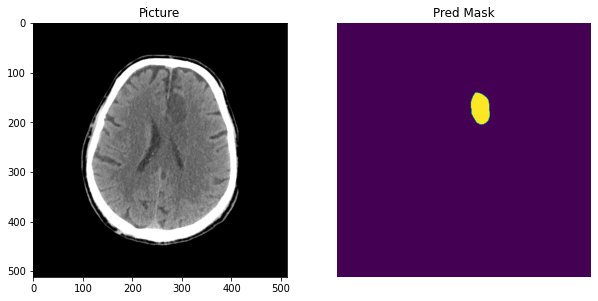

In [48]:
IMAGE_ID = 3
image2= test_set[IMAGE_ID]

pred_mask2 = predict_image_mask_miou(model, image2)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(image2)
ax1.set_title('Picture')

ax2.imshow(pred_mask2)
ax2.set_title('Pred Mask')
ax2.set_axis_off()

AttributeError: ignored

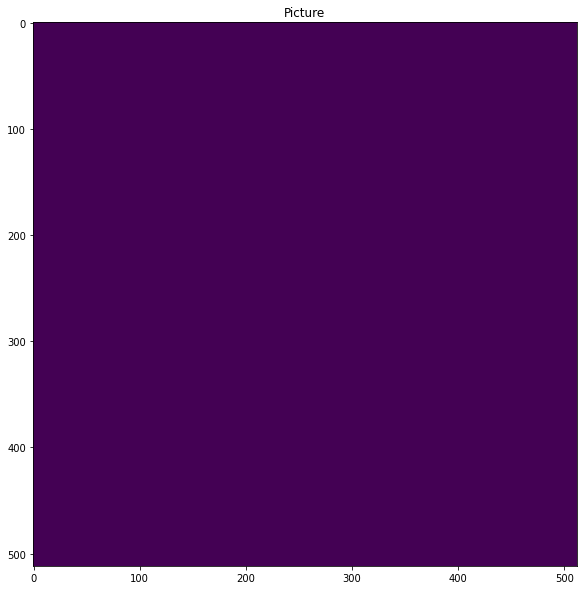

In [65]:
from torchvision import transforms

for idx,test_image_id in enumerate(X_test):
 
  test_image= test_set[idx]
  pred_mask = predict_image_mask_miou(model, test_image)
  fig, (ax1) = plt.subplots(1,1, figsize=(10,10))
  ax1.imshow(pred_mask)
  ax1.set_title('Picture')
  ax1.plot().get_figure().savefig('output.png')

